# Setup environment

In [1]:
!pip install -q --upgrade pip
!pip install -q -U tensorflow-gpu==2.0.0-alpha0

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from IPython.display import Image, display
from sklearn.model_selection import train_test_split

AUTOTUNE = tf.data.experimental.AUTOTUNE

# Inspect data

In [3]:
train_csv = pd.read_csv('../input/train.csv')
train_csv.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


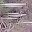

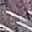

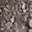

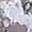

In [4]:
# Cactus
display(Image('../input/train/train/0004be2cfeaba1c0361d39e2b000257b.jpg'))
display(Image('../input/train/train/000c8a36845c0208e833c79c1bffedd1.jpg'))

# No cactus
display(Image('../input/train/train/002134abf28af54575c18741b89dd2a4.jpg'))
display(Image('../input/train/train/0024320f43bdd490562246435af4f90b.jpg'))

In [5]:
images = ['../input/train/train/' + fname for fname in train_csv['id']]
labels = train_csv['has_cactus'].tolist()

In [6]:
X_train, X_dev, y_train, y_dev = train_test_split(images, labels, test_size=0.1, random_state=42)
n_train = len(X_train)
n_dev = len(X_dev)

In [7]:
IMAGE_SIZE = 96

def preprocess_image(fname, label=None):
  img = tf.io.read_file(fname)
  img = tf.image.decode_jpeg(img)
  img = tf.cast(img, tf.float32)
  img = (img / 127.5) - 1
  img = tf.image.resize(img, size=(IMAGE_SIZE, IMAGE_SIZE))
  if label is not None:
    return img, label
  else:
    return img

In [8]:
BATCH_SIZE = 32 #@param

ds_train = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
            .map(preprocess_image, num_parallel_calls=AUTOTUNE)
            .shuffle(n_train)
            .batch(BATCH_SIZE)
            .prefetch(buffer_size=AUTOTUNE)
           )
ds_dev  = (tf.data.Dataset.from_tensor_slices((X_dev, y_dev))
           .map(preprocess_image, num_parallel_calls=AUTOTUNE)
           .shuffle(n_dev)
           .batch(BATCH_SIZE)
           .prefetch(buffer_size=AUTOTUNE)
          )

# Model

In [9]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top = False,
    weights = 'imagenet'
)
base_model.trainable = False
base_model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 97, 97, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalizationV1) (None, 48, 48, 32)   128         Conv1[0][0]                      
_________________

In [10]:
# My layers
pooling_layer = tf.keras.layers.GlobalMaxPooling2D()
final_layer = tf.keras.layers.Dense(units=1, activation='sigmoid')

In [11]:
model = tf.keras.Sequential([
    base_model,
    pooling_layer,
    final_layer
])

In [12]:
learning_rate = 0.0001
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Training

In [13]:
initial_epochs = 32
steps_per_epoch = (tf.math.ceil(n_train/BATCH_SIZE))
model.fit(
    ds_train.repeat(),
    epochs=initial_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=ds_dev
)

Epoch 1/32
493/493 [==============================] - 38s 78ms/step - loss: 0.4497 - accuracy: 0.8267 - val_loss: 0.4474 - val_accuracy: 0.7777
Epoch 2/32
493/493 [==============================] - 18s 37ms/step - loss: 0.1985 - accuracy: 0.9213 - val_loss: 0.4208 - val_accuracy: 0.8080
Epoch 3/32
493/493 [==============================] - 17s 34ms/step - loss: 0.1631 - accuracy: 0.9360 - val_loss: 0.3448 - val_accuracy: 0.8491
Epoch 4/32
493/493 [==============================] - 17s 34ms/step - loss: 0.1392 - accuracy: 0.9439 - val_loss: 0.2530 - val_accuracy: 0.8914
Epoch 5/32
493/493 [==============================] - 16s 33ms/step - loss: 0.1328 - accuracy: 0.9492 - val_loss: 0.2614 - val_accuracy: 0.8874
Epoch 6/32
493/493 [==============================] - 17s 35ms/step - loss: 0.1195 - accuracy: 0.9525 - val_loss: 0.2540 - val_accuracy: 0.8943
Epoch 7/32
493/493 [==============================] - 17s 35ms/step - loss: 0.1169 - accuracy: 0.9546 - val_loss: 0.2691 - val_accuracy:

# Fine Tune

In [14]:
base_model.trainable = True
len(base_model.layers)

155

In [15]:
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [16]:
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=learning_rate/10),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [17]:
fine_epochs = 32
total_epochs = initial_epochs + fine_epochs
model.fit(
    ds_train.repeat(),
    epochs=total_epochs,
    initial_epoch=initial_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=ds_dev
)

Epoch 33/64
493/493 [==============================] - 37s 76ms/step - loss: 0.0713 - accuracy: 0.9724 - val_loss: 0.0499 - val_accuracy: 0.9834
Epoch 34/64
493/493 [==============================] - 23s 47ms/step - loss: 0.0476 - accuracy: 0.9825 - val_loss: 0.0436 - val_accuracy: 0.9851
Epoch 35/64
493/493 [==============================] - 21s 43ms/step - loss: 0.0401 - accuracy: 0.9852 - val_loss: 0.0429 - val_accuracy: 0.9834
Epoch 36/64
493/493 [==============================] - 22s 44ms/step - loss: 0.0287 - accuracy: 0.9898 - val_loss: 0.0391 - val_accuracy: 0.9869
Epoch 37/64
493/493 [==============================] - 23s 46ms/step - loss: 0.0254 - accuracy: 0.9909 - val_loss: 0.0380 - val_accuracy: 0.9880
Epoch 38/64
493/493 [==============================] - 21s 43ms/step - loss: 0.0181 - accuracy: 0.9940 - val_loss: 0.0340 - val_accuracy: 0.9886
Epoch 39/64
493/493 [==============================] - 21s 43ms/step - loss: 0.0165 - accuracy: 0.9942 - val_loss: 0.0323 - val_ac

# Prediction

In [18]:
test_image_names = tf.io.gfile.listdir('../input/test/test/')
n_test = len(test_image_names)
test_image_paths = list(map(lambda s: '../input/test/test/' + s, test_image_names))

In [19]:
ds_test = (tf.data.Dataset.from_tensor_slices(test_image_paths)
            .map(preprocess_image, num_parallel_calls=AUTOTUNE)
            .batch(BATCH_SIZE)
            .prefetch(buffer_size=AUTOTUNE)
           )

In [20]:
predictions = model.predict(ds_test)

In [21]:
final_df = pd.DataFrame()
final_df['id'] = test_image_names
final_df['has_cactus'] = predictions

In [22]:
final_df.to_csv('submission.csv', index=False)